<a href="https://colab.research.google.com/github/salilathalye/cwa-templates-pycaret/blob/main/CWA_Binary_Classification_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1>Conversations with Austin</H1>
<h2>Binary Classifier Template
<p> Tested with PyCaret 2.2.3
<p>

Wait ... who is Austin, you ask? Austin the Apex Duck is my [Rubber Duck Debug buddy](https:en.wikipedia.org/wiki/Rubber_duck_debugging). Usually a pretty quiet type of guy, but I sense hidden depths of knowledge. Our chats usually start with me staring at something for a long time, then asking a question something like: "Hey Austin, what do you know about Kappa?". His usual response is: "Kappa? Tell me more, please". This usually starts a back and forth dialogue where he eggs (no pun intended!) me on to explain more. He's all about putting things in writing, which is why I'm sitting here taking notes which I'm cataloguing in a series called "Chats with Austin".

Salil Athalye
www.bokehboy.com


Data provided by [DPhi Tech](https://dphi.tech//) Assignment 3: Advanced: Loan or No Loan?
https://dphi.tech/practice/challenge/54


# Configure Environment and Install Packages


In [1]:
!pip install pycaret==2.2.3 --quiet
!pip install mlflow --quiet
!pip install shap --quiet

# Import Libraries


In [2]:
from datetime import datetime
from datetime import timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import json
from google.colab import files


# PyCaret
import pycaret
from pycaret.classification import * 
from pycaret.utils import enable_colab
enable_colab()


# MLflow
import mlflow
#TODO: How to set up an MLflow server which we can use with Colab? 
#mlflow.set_tracking_uri('file:/c:/users/mlflow-server')

import shap
#TODO: Not sure how PyCaret sets up shap.initjs() which is required for CoLab.

Colab mode enabled.


# Set Experiment Parameters


In [3]:
EXPERIMENT_NAME = 'dphi_ch54_1'
SESSION_ID = 3435
DATA_SOURCE = "https://raw.githubusercontent.com/dphi-official/Datasets/master/Loan_Data"
TRAINING_DATA = "loan_train.csv"
TEST_DATA = "loan_test.csv"
TARGET_COL = 'Loan_Status'
# Set this to False when converting this notebook to a Productions script
VERBOSE = True
# Optimize Threshold Costs (only for binary classifiers)
TP_COST = 0
TN_COST = 0
FP_COST = 0
FN_COST = 0
# Hyper-parameter search for model tuning
N_ITER = 10
# Should we download the run artifacts?
DOWNLOAD_ZIPFILE = True

In [4]:
MODEL = 'TBD' # we will populate this with the best model later

dt = datetime.now()
dt.replace(tzinfo=timezone.utc)
utc_timestamp = dt.replace(tzinfo=timezone.utc).isoformat(timespec='seconds')
# Replace ':' and '-' and retain up to seconds
UTC_TIMESTAMP = utc_timestamp.replace(':','').replace('-',"")[:15]

TRAINING_DATA_PATH = DATA_SOURCE + '/' + TRAINING_DATA
TEST_DATA_PATH = DATA_SOURCE + '/' + TEST_DATA

# Load the data


In [5]:
# Dataset is provided by DPhi Tech
# raw.githubusercontent.com allows us to download 'raw' content of files stored on github
# NOTE: the training data was most likely saved out without setting index=False, so we need to get rid of the index column on read.
# This is only an issue for the training data file, test data file is fine.
# Credit_History comes in as a float, due to missing values and how pandas manages na_type_promotions
# Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#na-type-promotions
dtype_mapping = {}
training_data  = pd.read_csv(TRAINING_DATA_PATH, dtype=dtype_mapping, index_col=[0])
test_data = pd.read_csv(TEST_DATA_PATH, dtype=dtype_mapping)

# Save the raw data in case the source is unavailable later
training_data.to_csv(TRAINING_DATA, index=False)
test_data.to_csv(TEST_DATA, index=False)
# Save any decisions we took on dtype mapping so we can reuse this in other applications
with open('dtype_mapping.json','w') as f:
  json.dump(dtype_mapping, f)

###Data Description
* Loan_ID: A unique ID assigned to every loan applicant
* Gender: Gender of the applicant (Male, Female)
* Married: The marital status of the applicant (Yes, No)
* Dependents: No. of people dependent on the applicant (0,1,2,3+)
* Education: Education level of the applicant (Graduated, Not Graduated)
* Self_Employed: If the applicant is self-employed or not (Yes, No)
* ApplicantIncome: The amount of income the applicant earns
* CoapplicantIncome: The amount of income the co-applicant earns
* LoanAmount: The amount of loan the applicant has requested for
* Loan_Amount_Term: The  no. of days over which the loan will be paid
* Credit_History: A record of a borrower's responsible repayment of debts (1- has all debts paid, 0- not paid)
* Property_Area : The type of location where the applicant’s property lies (Rural, Semiurban, Urban)
* Loan_Status: Loan granted or not (1 for granted, 0 for not granted)

<p>
Target: Loan_Status, binary




In [6]:
test_data.shape

(123, 12)

In [7]:
training_data.shape

(491, 13)

### Compare Training Data Columns to Test Data Columns

In [8]:
training_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [9]:
test_data_columns = test_data.columns
training_data_columns = training_data.columns
#Set difference : columns in training_data that are not in test_data
columns_missing_in_test = set(training_data_columns) - set(test_data_columns)
print(columns_missing_in_test)

{'Loan_Status'}


In [10]:
training_data.head(5)

Loan_ID  Gender Married Dependents     Education Self_Employed  \
0  LP002305  Female      No          0      Graduate            No   
1  LP001715    Male     Yes         3+  Not Graduate           Yes   
2  LP002086  Female     Yes          0      Graduate            No   
3  LP001136    Male     Yes          0  Not Graduate           Yes   
4  LP002529    Male     Yes          2      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             4547                0.0       115.0             360.0   
1             5703                0.0       130.0             360.0   
2             4333             2451.0       110.0             360.0   
3             4695                0.0        96.0               NaN   
4             6700             1750.0       230.0             300.0   

   Credit_History Property_Area  Loan_Status  
0             1.0     Semiurban            1  
1             1.0         Rural            1  
2             1.0         Urban            0  
3             1.0         Urban            1  
4             1.0     Semiurban            1

In [11]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 0 to 490
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            491 non-null    object 
 1   Gender             481 non-null    object 
 2   Married            490 non-null    object 
 3   Dependents         482 non-null    object 
 4   Education          491 non-null    object 
 5   Self_Employed      462 non-null    object 
 6   ApplicantIncome    491 non-null    int64  
 7   CoapplicantIncome  491 non-null    float64
 8   LoanAmount         475 non-null    float64
 9   Loan_Amount_Term   478 non-null    float64
 10  Credit_History     448 non-null    float64
 11  Property_Area      491 non-null    object 
 12  Loan_Status        491 non-null    int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 53.7+ KB


In [12]:
training_data.isna().sum()

Loan_ID               0
Gender               10
Married               1
Dependents            9
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           16
Loan_Amount_Term     13
Credit_History       43
Property_Area         0
Loan_Status           0
dtype: int64

In [13]:
training_data.describe()

ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       491.000000         491.000000  475.000000        478.000000   
mean       5401.189409        1589.730998  145.014737        341.297071   
std        6419.427177        2919.320624   86.310534         66.964051   
min         150.000000           0.000000   17.000000         12.000000   
25%        2923.500000           0.000000  100.000000        360.000000   
50%        3865.000000        1229.000000  126.000000        360.000000   
75%        5705.500000        2251.500000  162.000000        360.000000   
max       81000.000000       41667.000000  700.000000        480.000000   

       Credit_History  Loan_Status  
count      448.000000   491.000000  
mean         0.848214     0.698574  
std          0.359214     0.459345  
min          0.000000     0.000000  
25%          1.000000     0.000000  
50%          1.000000     1.000000  
75%          1.000000     1.000000  
max          1.000000     1.000000

In [14]:
training_data[TARGET_COL].value_counts()

1    343
0    148
Name: Loan_Status, dtype: int64

# Perform Basic Exploratory Data Analysis


# Set up the Experiment
### Notes
* Only set silent=True when you are sure that PyCaret has interpreted the type of each feature correctly. Also remember that if use the default (silent=False), **PyCaret will pause here**, waiting for user confirmation!!!
* When you migrate to Production in the form of a Python script then set html=False.


In [15]:
experiment = setup(training_data, 
                    target = TARGET_COL, 
                    session_id=SESSION_ID, 
                    ignore_features=['Loan_ID'], # Loan_ID is a key
                    numeric_features=['LoanAmount','ApplicantIncome','CoapplicantIncome','Loan_Amount_Term'],
                    imputation_type="iterative", 
                    categorical_iterative_imputer="lightgbm", 
                    numeric_iterative_imputer="lightgbm", 
                    iterative_imputation_iters = 5,
                    normalize = True,
                    fix_imbalance = True,
                    fix_imbalance_method = None, # will use SMOTE when set to None
                    fold_strategy='stratifiedkfold',
                    log_experiment = True,       # sets up MLflow using local files
                    log_plots=True,
                    log_data=True,
                    experiment_name = EXPERIMENT_NAME,
                    silent=True,                 # set to True only when you confirm feature types selected by PyCaret
                    #html=False                  # set to False when converting this to a Production script
                   )

Description                            Value
0                               session_id                             3435
1                                   Target                      Loan_Status
2                              Target Type                           Binary
3                            Label Encoded                       0: 0, 1: 1
4                            Original Data                        (491, 13)
5                           Missing Values                             True
6                         Numeric Features                                4
7                     Categorical Features                                7
8                         Ordinal Features                            False
9                High Cardinality Features                            False
10                 High Cardinality Method                             None
11                   Transformed Train Set                        (343, 16)
12                    Transformed Test Set                        (148, 16)
13                      Shuffle Train-Test                             True
14                     Stratify Train-Test                            False
15                          Fold Generator                  StratifiedKFold
16                             Fold Number                               10
17                                CPU Jobs                               -1
18                                 Use GPU                            False
19                          Log Experiment                             True
20                         Experiment Name                      dphi_ch54_1
21                                     USI                             ac86
22                         Imputation Type                        iterative
23          Iterative Imputation Iteration                                5
24                         Numeric Imputer                             mean
25      Iterative Imputation Numeric Model  Light Gradient Boosting Machine
26                     Categorical Imputer                         constant
27  Iterative Imputation Categorical Model  Light Gradient Boosting Machine
28           Unknown Categoricals Handling                   least_frequent
29                               Normalize                             True
30                        Normalize Method                           zscore
31                          Transformation                            False
32                   Transformation Method                             None
33                                     PCA                            False
34                              PCA Method                             None
35                          PCA Components                             None
36                     Ignore Low Variance                            False
37                     Combine Rare Levels                            False
38                    Rare Level Threshold                             None
39                         Numeric Binning                            False
40                         Remove Outliers                            False
41                      Outliers Threshold                             None
42                Remove Multicollinearity                            False
43             Multicollinearity Threshold                             None
44                              Clustering                            False
45                    Clustering Iteration                             None
46                     Polynomial Features                            False
47                       Polynomial Degree                             None
48                    Trignometry Features                            False
49                    Polynomial Threshold                             None
50                          Group Features                            False
51                       Feature Selection                            False
52 

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


#PyCaret Pipeline
PyCaret creates a Pipeline behind the scenes. Using get_config() we can output a description of the steps in the Pipeline.
<p>
TODO: Figure out how to save the pipeline description to JSON, perhaps?

In [16]:
prep_pipe = get_config('prep_pipe')

In [17]:
prep_pipe

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['Loan_ID'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['LoanAmount',
                                                          'ApplicantIncome',
                                                          'CoapplicantIncome',
                                                          'Loan_Amount_Term'],
                                      target='Loan_Status', time_features=[])),
                ('imputer',
                 Iterative_Imputer(add_indicator=Fal...
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                (

# Feature Transformations
Review how PyCaret has transformed Features and the Target looking only at the training data to avoid data leakage.
This is useful when we start developing the front-end and the API so we can be specific on what categorical values are allowed.
<p>
TODO: Seems like we have to infer what transformations were made to each Feature. Would like to see something like col_a was Normalized, col_b was One Hot Encoded etc.

In [18]:
transformed_training_features = get_config('X_train')

In [19]:
transformed_training_features.T[0]

ApplicantIncome             -0.127816
CoapplicantIncome           -0.503953
LoanAmount                 115.000000
Loan_Amount_Term           360.000000
Gender_Male                  0.000000
Married_Yes                  0.000000
Dependents_0                 1.000000
Dependents_1                 0.000000
Dependents_2                 0.000000
Dependents_3+                0.000000
Education_Not Graduate       0.000000
Self_Employed_Yes            0.000000
Credit_History_1.0           1.000000
Property_Area_Rural          0.000000
Property_Area_Semiurban      1.000000
Property_Area_Urban          0.000000
Name: 0, dtype: float64

#Evaluate, Select and Tune Model

## Compare Models


In [20]:
# return best model based on F1
best = compare_models(sort = 'F1', fold=5) #default is 'Accuracy'

Model  Accuracy     AUC  Recall   Prec.  \
qda       Quadratic Discriminant Analysis    0.7783  0.7115  0.9915  0.7609   
catboost              CatBoost Classifier    0.7786  0.7282  0.9113  0.7983   
ridge                    Ridge Classifier    0.7783  0.0000  0.9024  0.8015   
lda          Linear Discriminant Analysis    0.7783  0.7412  0.9024  0.8015   
gbc          Gradient Boosting Classifier    0.7754  0.7353  0.9027  0.7991   
rf               Random Forest Classifier    0.7639  0.7125  0.9026  0.7875   
lightgbm  Light Gradient Boosting Machine    0.7549  0.7067  0.8645  0.7981   
ada                  Ada Boost Classifier    0.7435  0.6841  0.8645  0.7871   
lr                    Logistic Regression    0.7463  0.7378  0.8518  0.7962   
nb                            Naive Bayes    0.7434  0.7137  0.8602  0.7904   
xgboost         Extreme Gradient Boosting    0.7464  0.7150  0.8433  0.8005   
et                 Extra Trees Classifier    0.7348  0.7058  0.8475  0.7856   
dt               Decision Tree Classifier    0.7292  0.6811  0.8093  0.7989   
knn                K Neighbors Classifier    0.4694  0.4399  0.5043  0.6500   
svm                   SVM - Linear Kernel    0.5333  0.0000  0.6000  0.4107   

              F1   Kappa     MCC  TT (Sec)  
qda       0.8606  0.3618  0.4529     0.042  
catboost  0.8498  0.4345  0.4561     1.920  
ridge     0.8489  0.4393  0.4492     0.028  
lda       0.8489  0.4393  0.4492     0.028  
gbc       0.8469  0.4306  0.4461     0.120  
rf        0.8402  0.3954  0.4140     0.582  
lightgbm  0.8290  0.3983  0.4054     0.066  
ada       0.8228  0.3606  0.3692     0.120  
lr        0.8225  0.3797  0.3831     0.780  
nb        0.8220  0.3618  0.3715     0.032  
xgboost   0.8207  0.3882  0.3910     0.310  
et        0.8146  0.3503  0.3565     0.554  
dt        0.8035  0.3662  0.3682     0.030  
knn       0.5670 -0.0937 -0.0960     0.146  
svm       0.4876  0.0000  0.0000     0.030

In [21]:
compare_model_results = pull()
compare_model_results.to_csv('compare_model.csv', index=False)

## Select the Base Model
### Notes for Austin
* Austin, when we want to study the decision boundaries that are established by different types of models, we can use create_model to run these experiments.

### Do your research!
* Is there a way to take the output from compare_models() and feed it into create model? Looks like compare_models() returns an object, whereas create_model needs a model identifier as a str.
* Future iteration, let's get a top N set of models that we can use for a bagging,blending,stacking foray! What would be a good criteria for going down this path? Can we establish a parallel path, or perhaps a choice?

In [22]:
# explicitly set MODEL - ideally would like to automate this by getting the model string from compare_models()
MODEL = 'catboost'

In [23]:
# train base model
base_model = create_model(MODEL, verbose=True)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7714  0.7576  0.8333  0.8333  0.8333  0.4697  0.4697
1       0.8000  0.8523  0.9167  0.8148  0.8627  0.4990  0.5109
2       0.7714  0.7348  0.9167  0.7857  0.8462  0.4118  0.4308
3       0.6176  0.4750  0.8333  0.6897  0.7547 -0.0780 -0.0858
4       0.8529  0.8500  0.9583  0.8519  0.9020  0.6119  0.6292
5       0.7353  0.6375  0.9167  0.7586  0.8302  0.2537  0.2787
6       0.7941  0.8063  0.9565  0.7857  0.8627  0.4664  0.5045
7       0.7353  0.6008  0.8696  0.7692  0.8163  0.3489  0.3575
8       0.7941  0.6957  0.9565  0.7857  0.8627  0.4664  0.5045
9       0.8235  0.7945  0.9130  0.8400  0.8750  0.5768  0.5826
Mean    0.7696  0.7204  0.9071  0.7915  0.8446  0.4026  0.4183
SD      0.0612  0.1143  0.0448  0.0451  0.0380  0.1877  0.1936

In [24]:
create_model_results = pull()
create_model_results.to_csv('create_model.csv', index=False)

## Tune the Model


In [25]:

optimized_threshold = optimize_threshold(base_model, true_negative=TN_COST, false_negative=FN_COST, true_positive=TP_COST, false_positive=TN_COST)
print(optimized_threshold)


Optimized Probability Threshold: 0.0 | Optimized Cost Function: 0
0.0


In [26]:
optimized_threshold_results = {'TP_COST': TP_COST, 'TN_COST': TN_COST, 'FP_COST': FP_COST, 'FN_COST': FN_COST, 'OPT_THRESHOLD': optimized_threshold}
with open("optimized_threshold_results.json",'w') as f:
  json.dump(optimized_threshold_results, f)

In [27]:
# tune hyperparameters to optimize F1
tuned_model = tune_model(base_model, optimize = 'F1', n_iter=N_ITER)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8571  0.8030  1.0000  0.8276  0.9057  0.6220  0.6719
1       0.8571  0.9091  1.0000  0.8276  0.9057  0.6220  0.6719
2       0.7714  0.7614  0.9583  0.7667  0.8519  0.3778  0.4271
3       0.7059  0.5333  0.9583  0.7188  0.8214  0.0761  0.1130
4       0.8824  0.8917  1.0000  0.8571  0.9231  0.6792  0.7171
5       0.7353  0.6896  0.9583  0.7419  0.8364  0.1990  0.2544
6       0.8235  0.8379  1.0000  0.7931  0.8846  0.5300  0.6004
7       0.7353  0.6443  0.8696  0.7692  0.8163  0.3489  0.3575
8       0.7647  0.6917  1.0000  0.7419  0.8519  0.3366  0.4498
9       0.8529  0.8063  1.0000  0.8214  0.9020  0.6188  0.6694
Mean    0.7986  0.7568  0.9745  0.7865  0.8699  0.4410  0.4932
SD      0.0600  0.1113  0.0396  0.0435  0.0369  0.1942  0.1957

In [28]:
tune_model_results = pull()
tune_model_results.to_csv('tune_model.csv', index=False)

## Review Model Diagnostics
### Notes for Austin
* This is where we need to spend some quality time. Surfacing the insights from a set of runs to inform our next choices. Especially true when you are running complex models on cloud clusters --- the $$$ start to rack up.
* Let's invest in a deep study of these plots and formulate an approach

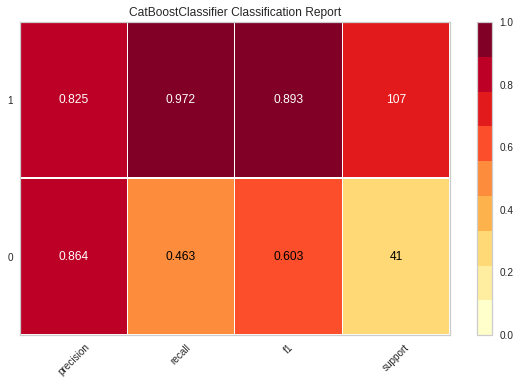

In [29]:
plot_model(tuned_model, plot = 'class_report')

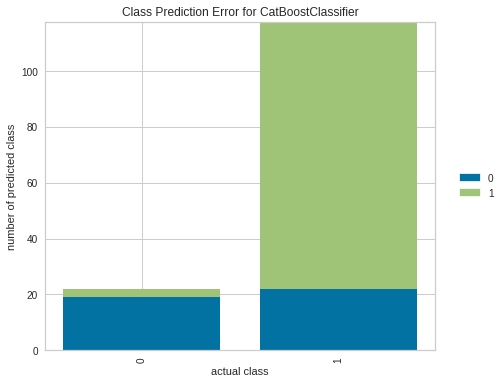

In [30]:
plot_model(tuned_model, plot='error')

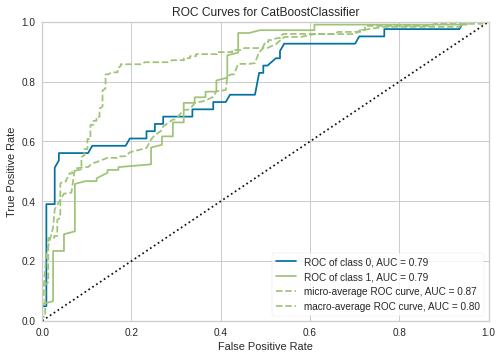

In [31]:
#plot a model
plot_model(tuned_model, plot='auc')

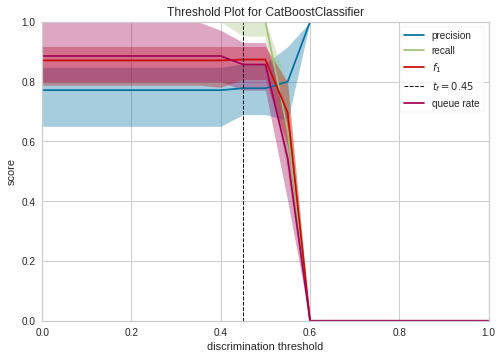

In [32]:
plot_model(tuned_model, plot='threshold')

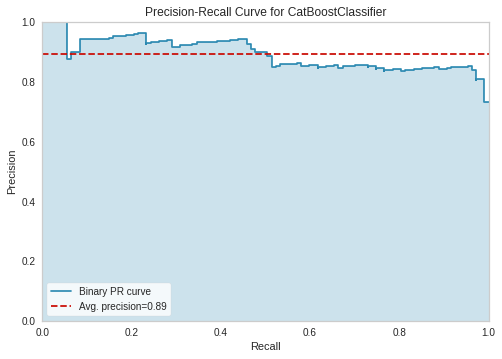

In [33]:
plot_model(tuned_model, plot = 'pr')

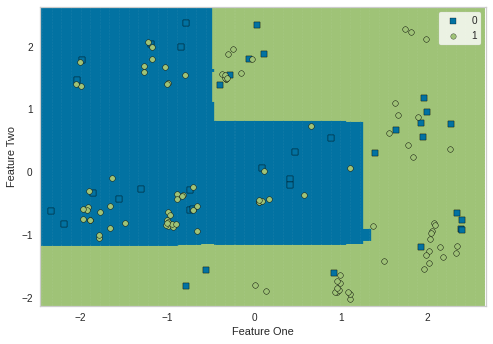

In [34]:
plot_model(tuned_model, plot='boundary')

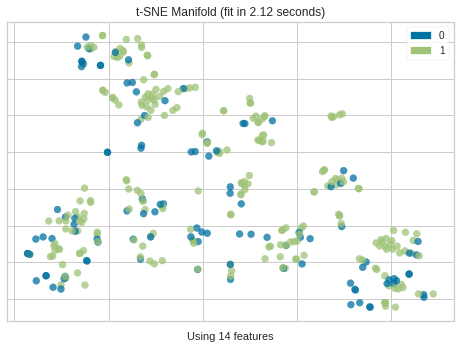

In [35]:
plot_model(tuned_model, plot='manifold')

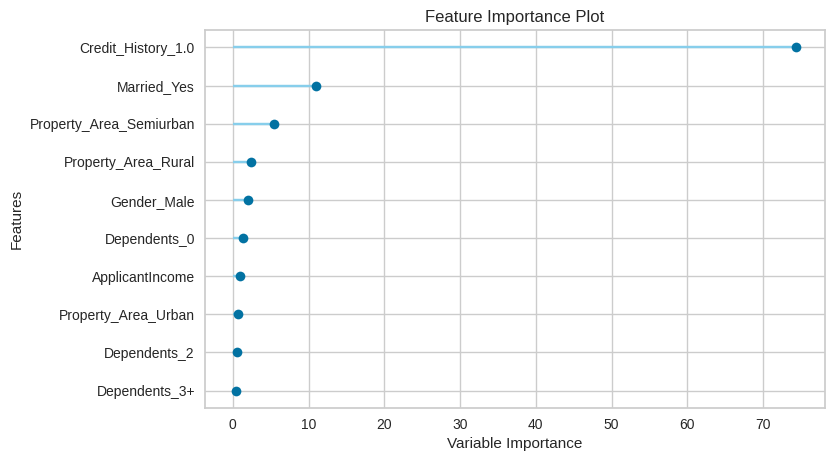

In [36]:

plot_model(tuned_model, plot='feature')

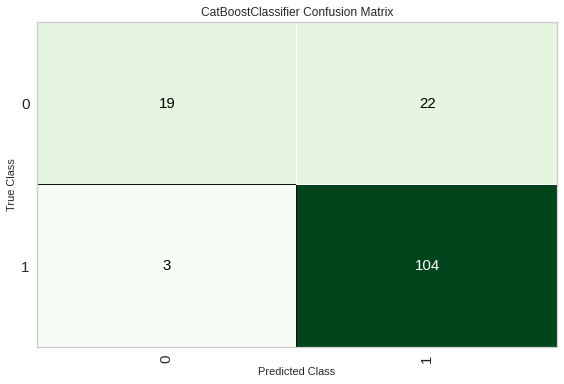

In [37]:
plot_model(tuned_model, plot = 'confusion_matrix')

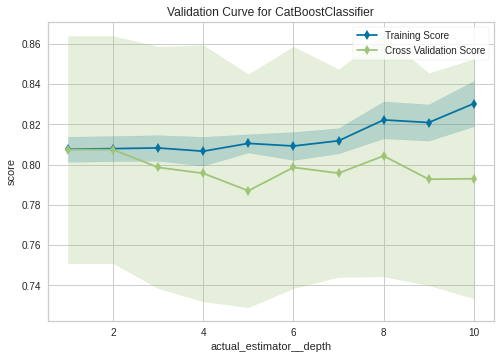

In [38]:
plot_model(tuned_model, plot='vc')

In [39]:
predict_model(tuned_model)

Model  Accuracy     AUC  Recall   Prec.      F1  Kappa     MCC
0  CatBoost Classifier    0.8311  0.7935   0.972  0.8254  0.8927  0.508  0.5477

ApplicantIncome  CoapplicantIncome  LoanAmount  ...  Loan_Status  Label   Score
0          -0.548585           0.075210        74.0  ...            1      1  0.5280
1           0.065044           1.184896       187.0  ...            1      1  0.5857
2          -0.202069          -0.503953       124.0  ...            1      1  0.5365
3          -0.198082          -0.503953       115.0  ...            1      1  0.5493
4           0.064213          -0.503953       128.0  ...            1      1  0.5682
..               ...                ...         ...  ...          ...    ...     ...
143         0.501096           0.621946       187.0  ...            1      1  0.5210
144        -0.267851           0.096527       120.0  ...            1      1  0.5544
145        -0.052566          -0.503953       132.0  ...            1      1  0.5188
146        -0.258216          -0.003753       135.0  ...            1      1  0.5187
147        -0.301738          -0.178793       135.0  ...            1      1  0.5666

[148 rows x 19 columns]

##Interpret Model Predictions
<p>
If you are viewing this notebook on github, the next set of plots will not render as they require Javascript. SHAP interpretation

In [40]:
shap_models = ['xgboost', 'rf', 'catboost', 'et', 'lightgbm', 'dt']
run_shap = True if MODEL in shap_models else False
print(f'Cannot run SHAP model interpretation for {MODEL}' if run_shap == False else 'Running SHAP model interpretation. Plots require Javascript and may not render on github')

Running SHAP model interpretation. Plots require Javascript and may not render on github


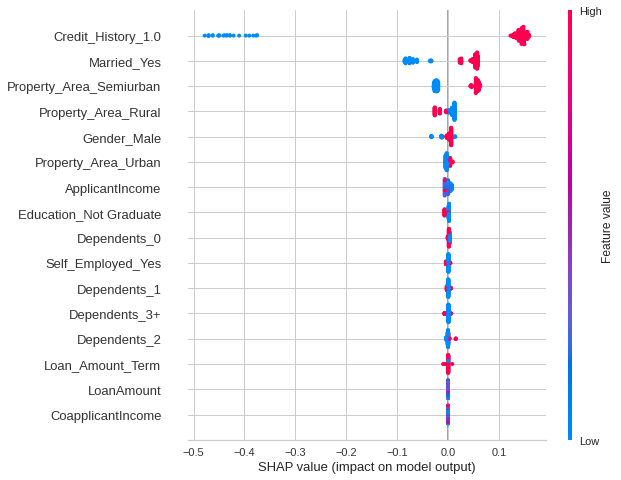

In [41]:
if run_shap:
  interpret_model(tuned_model)

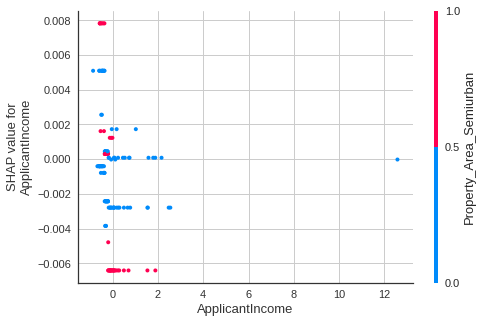

In [42]:
if run_shap:
  interpret_model(tuned_model, plot='correlation')

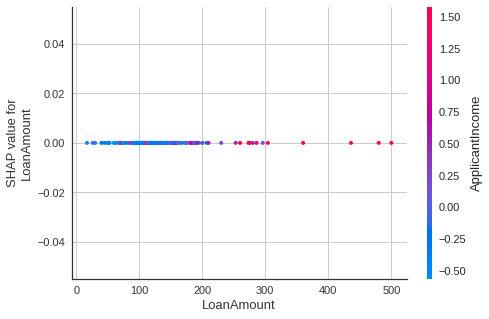

In [43]:
if run_shap:
  interpret_model(tuned_model, plot='correlation', feature='LoanAmount')

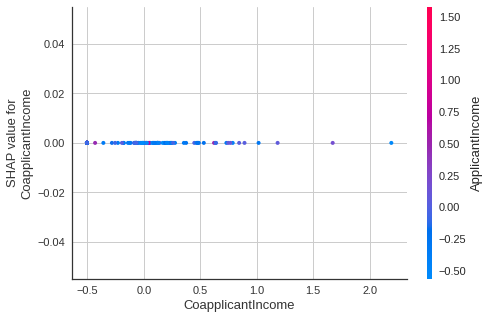

In [44]:
if run_shap:
  interpret_model(tuned_model, plot='correlation', feature='CoapplicantIncome')

In [45]:
interpret_model(tuned_model, plot='reason')

In [46]:
i = 77
interpret_model(tuned_model, plot='reason', observation = i)

In [47]:
explainer = shap.TreeExplainer(tuned_model)
base_value = explainer.expected_value[0]
print(base_value)
shap_values = explainer.shap_values(transformed_training_features)
i = 77
values = shap_values[i,:]
features = transformed_training_features.columns
data = transformed_training_features.iloc[i,:]
# There is curently a bug in waterfall_plot, see
# https://github.com/slundberg/shap/issues/1420
# This is a workaround.
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], feature_names=features)

0.06585861307972127


In [48]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Finalize the Model

In [49]:
final_model = finalize_model(tuned_model)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


In [50]:
print(final_model)

In [51]:
FINAL_MODEL_NAME_WITH_TS = EXPERIMENT_NAME + '_' + MODEL + '_' + UTC_TIMESTAMP
FINAL_MODEL_NAME_WITHOUT_TS = EXPERIMENT_NAME + '_' + MODEL

* Not sure if there are issues with putting a timestamp or a file name length constraint for cloud environments. I recall that Azure Machine Learning had an experiment name string length limit. For now, I will save the model again with a simple file name without the timestamp.

In [52]:
save_model(final_model, FINAL_MODEL_NAME_WITHOUT_TS)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Loan_ID'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['LoanAmount',
                                                           'ApplicantIncome',
                                                           'CoapplicantIncome',
                                                           'Loan_Amount_Term'],
                                       target='Loan_Status', time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=Fal...
                 ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Loan_Status')),
                

In [53]:
save_model(final_model, FINAL_MODEL_NAME_WITH_TS)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Loan_ID'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['LoanAmount',
                                                           'ApplicantIncome',
                                                           'CoapplicantIncome',
                                                           'Loan_Amount_Term'],
                                       target='Loan_Status', time_features=[])),
                 ('imputer',
                  Iterative_Imputer(add_indicator=Fal...
                 ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Loan_Status')),
                

In [54]:
!ls

catboost_info				  logs.log
compare_model.csv			  mlruns
create_model.csv			  notebook_package_versions.json
dphi_ch54_1_catboost_20210103T200418.pkl  optimized_threshold_results.json
dphi_ch54_1_catboost_20210103T200418.zip  prediction_results.csv
dphi_ch54_1_catboost_20210104T004226.pkl  test_data_columns.json
dphi_ch54_1_catboost.pkl		  test_data_dtypes.json
dphi_ch54_1_logs.csv			  training_data_columns.json
dtype_mapping.json			  training_data_dtypes.json
loan_test.csv				  tune_model.csv
loan_train.csv


# Load Model and Predict


In [55]:
loaded_model = load_model(FINAL_MODEL_NAME_WITHOUT_TS)

Transformation Pipeline and Model Successfully Loaded


In [56]:
loaded_model

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['Loan_ID'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['LoanAmount',
                                                          'ApplicantIncome',
                                                          'CoapplicantIncome',
                                                          'Loan_Amount_Term'],
                                      target='Loan_Status', time_features=[])),
                ('imputer',
                 Iterative_Imputer(add_indicator=Fal...
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='Loan_Status')),
                ('fix_perfect', 

In [57]:
single_example = test_data.iloc[[1],:]

In [58]:
single_example.head()

Loan_ID Gender Married  ... Loan_Amount_Term Credit_History Property_Area
1  LP001488   Male     Yes  ...            360.0            1.0     Semiurban

[1 rows x 12 columns]

In [59]:
single_example.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 1 to 1
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            1 non-null      object 
 1   Gender             1 non-null      object 
 2   Married            1 non-null      object 
 3   Dependents         1 non-null      object 
 4   Education          1 non-null      object 
 5   Self_Employed      1 non-null      object 
 6   ApplicantIncome    1 non-null      int64  
 7   CoapplicantIncome  1 non-null      float64
 8   LoanAmount         1 non-null      float64
 9   Loan_Amount_Term   1 non-null      float64
 10  Credit_History     1 non-null      float64
 11  Property_Area      1 non-null      object 
dtypes: float64(4), int64(1), object(7)
memory usage: 104.0+ bytes


In [60]:
prediction = predict_model(loaded_model, data= single_example)

In [61]:
prediction

Loan_ID Gender Married  ... Property_Area Label   Score
1  LP001488   Male     Yes  ...     Semiurban     1  0.5992

[1 rows x 14 columns]

In [62]:
batch_prediction = predict_model(loaded_model, data=test_data)

In [63]:
batch_prediction

Loan_ID  Gender Married  ... Property_Area Label   Score
0    LP001116    Male      No  ...     Semiurban     1  0.5826
1    LP001488    Male     Yes  ...     Semiurban     1  0.5992
2    LP002138    Male     Yes  ...         Rural     1  0.5371
3    LP002284    Male      No  ...         Rural     1  0.5189
4    LP002328    Male     Yes  ...         Rural     0  0.6142
..        ...     ...     ...  ...           ...   ...     ...
118  LP002683    Male      No  ...     Semiurban     1  0.5866
119  LP002054    Male     Yes  ...         Rural     1  0.5327
120  LP002757  Female     Yes  ...     Semiurban     1  0.5898
121  LP002582  Female      No  ...     Semiurban     1  0.5747
122  LP001616    Male     Yes  ...     Semiurban     1  0.5954

[123 rows x 14 columns]

In [64]:
submission = batch_prediction[['Label']]
submission.rename(columns={'Label':'prediction'}, inplace=True)
submission.index = test_data.index
submission.to_csv('prediction_results.csv', index=False)

In [65]:
logs = get_logs(save=True)
logs.head()

run_id  ...  tags.URI
0  6e07ce6e0d4a4062b6248f631c7aa069  ...  665c46f1
1  c1345040fa504a449a6cb7bfbfedd9d2  ...  07f9ee68
2  935ae00280734057a0a0e32e90a7e935  ...  2a22f751
3  98d58cb8a351404d80fa522f534452e3  ...  d4ebf4ed
4  d2df842c92ef47acaeb340b35bd2db4b  ...  d4ebf4ed

[5 rows x 205 columns]

# Capture Schema Information



In [66]:
import json

def schema_to_json(df, filename_prefix):
  '''
  Adapted from
  Source: https://stackoverflow.com/questions/50422404/save-and-export-dtypes-information-of-a-python-pandas-dataframe
  '''
  columns_filename = filename_prefix + '_columns.json'
  df.head(0).to_json(columns_filename)

  tmp = df.dtypes.to_frame('dtypes').reset_index()
  df_dtypes = tmp.set_index('index')['dtypes'].astype(str).to_dict()
  dtypes_filename = filename_prefix + '_dtypes.json'
  with open(dtypes_filename, 'w') as f:
    json.dump(df_dtypes, f)

In [67]:
schema_to_json(training_data, 'training_data')
schema_to_json(test_data, 'test_data')

# Capture Package Versions


In [68]:
'''
Adapted from
Source: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
'''
package_versions = {m.__name__ : m.__version__ for m in globals().values() if getattr(m, '__version__', None)}
with open('notebook_package_versions.json','w') as f:
  json.dump(package_versions, f)

# Bundle Outputs and Download

In [69]:
# Google Colab places a folder of sample data in sample_data. We don't need that.
!rm -rf sample_data ||:

In [70]:
ZIP_ARCHIVE_NAME = FINAL_MODEL_NAME_WITH_TS + '.zip'

In [71]:
!zip -qr ./$ZIP_ARCHIVE_NAME ./

In [72]:
if DOWNLOAD_ZIPFILE:
  files.download(ZIP_ARCHIVE_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>